#**Assignment 2 - Network Anomaly Detection**

###**Presented By:-**

####**Name1:** Ali Hassan Ali Ahmed ElSharawy - **ID1:** 19016013
####**Name2:** Ziad Mohamed Abuelkher  - **ID2:** 19015733
####**Name3:** Youssef Magdy Helmy - **ID3:** 19016937

#Problem Statement:

####The exponential growth of network traffic has led to an increase in network anomalies, such as cyber attacks, network failures, and hardware malfunctions. Network anomaly detection is a critical task for maintaining the security and stability of computer networks. The objective of this assignment is to help students understand how K-Means and Normalized Cut algorithms can be used for network anomaly detection.

###**Imports**

In [ ]:
from google.colab import drive
import os
import zipfile
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import random as rd
import pickle
from scipy.spatial.distance import cdist
from scipy.stats import entropy
from sklearn.cluster import SpectralClustering

##**Global Variables**

data_labeled_kmeans --> np array for labeled data of Kmeans - 10% file  
data_labeled_spectral --> np array for unlabeled data used in spectral clustering - 5M rows file  
test_labeled --> np array for labeled tests dataset  

data_kmeans --> unlabeled data for kmeans.  
data_spectral --> unlabeled data for spectral clustering.  
data_spectral_labels --> labels of the spectral clustering dataset (last column).  
test --> unlabeled test dataset.  

kmeans_dict --> dictionary used to convert categorical data to numerical (in rows 1, 2, 3, 41)  
spectral_dict --> same idea but on spectral data  
test_dict --> same idea but on test dataset  


#1 Download Datset and Understand the Format

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Lab2/Datasets"
os.chdir(path)
print("Current directory:", os.getcwd())
print("Files inside folder:", os.listdir())

Current directory: /content/drive/MyDrive/Lab2/Datasets
Files inside folder: ['corrected.gz', 'kddcup.data.gz', 'kddcup.data_10_percent.gz']


In [ ]:
class Get_Data:
  def __init__(self, data_path_kmeans, data_path_spectral, test_path, printFlag):
    self.data_path_kmeans = data_path_kmeans
    self.data_path_spectral = data_path_spectral
    self.test_path = test_path
    self.printFlag = printFlag
    self.data_kmeans = 0
    self.data_spectral = 0
    self.test = 0
    self.encoded_dict_kmeansData = {}
    self.encoded_dict_spectralData = {}
    self.encoded_dict_test = {}

    self.getData()
  
  def _saveToDF(self, path):
    return pd.read_csv(path, header=None)

  def _getCatCols(self, df):
    data_cols = []
    for col in df.columns:
      if df[col].dtype == 'object':
        data_cols.append(col)
    if(self.printFlag):
      print("Columns containing categorical data: " + str(data_cols))
    return data_cols

# cat_cols = categorical columns
  def _encodeCategories(self, df, cat_cols):
    label_encoders = {}
    encodings_dict = {}
    for col in cat_cols: 
      currentEncode = LabelEncoder()
      df[col] = np.array(currentEncode.fit_transform(df[col]))
      label_encoders[col] = df[col]
      encodings_dict[col] = dict(zip(currentEncode.inverse_transform(range(len(currentEncode.classes_))), range(len(currentEncode.classes_))))

    print(df.to_numpy()[:6,41])
    print(encodings_dict[41])
    return df.to_numpy(), encodings_dict

  def getData(self):
    currentDF = [self._saveToDF(self.data_path_kmeans), self._saveToDF(self.data_path_spectral), self._saveToDF(self.test_path)]
    
    if(self.printFlag):
      print(f"Head of stored data DF:\n{currentDF[0].head()}")
      print(f"Head of stored data DF:\n{currentDF[1].head()}")
      print(f"Head of stored test DF:\n{currentDF[2].head()}")

    dataToStore = []
    dictToStore = []

    for df in currentDF:
      colsOfCategories = self._getCatCols(df) # 1,2,3,41
      data, curDict = self._encodeCategories(df, colsOfCategories)
      dataToStore.append(data)
      dictToStore.append(curDict)

    self.data_kmeans = dataToStore[0]
    self.data_spectral = dataToStore[1]
    self.test = dataToStore[2]

    self.encoded_dict_kmeansData = dictToStore[0]
    self.encoded_dict_spectralData = dictToStore[1]
    self.encoded_dict_test = dictToStore[2]
    pass

Dataset is downloaded to our drive, in: 'MyDrive/Lab2/Datasets'.

There are 2 files that matter with us:  
- The unlabled initial data, which has 4898431 rows (samples), and 42 columns (41 features + 1 labels).  
- The labled corrected data, which has 311029 rows (samples), and 42 columns.

In [ ]:
data_path_kmeans = '/content/drive/MyDrive/Lab2/Datasets/kddcup.data_10_percent.gz'
data_path_spectral = '/content/drive/MyDrive/Lab2/Datasets/kddcup.data.gz'
test_path = '/content/drive/MyDrive/Lab2/Datasets/corrected.gz'
getData = Get_Data(data_path_kmeans, data_path_spectral, test_path, True)
data_labeled_kmeans = getData.data_kmeans
data_labeled_spectral = getData.data_spectral
test = getData.test

Head of stored data DF:
   0    1     2   3    4     5   6   7   8   9   ...  32   33   34    35   36  \
0   0  tcp  http  SF  181  5450   0   0   0   0  ...   9  1.0  0.0  0.11  0.0   
1   0  tcp  http  SF  239   486   0   0   0   0  ...  19  1.0  0.0  0.05  0.0   
2   0  tcp  http  SF  235  1337   0   0   0   0  ...  29  1.0  0.0  0.03  0.0   
3   0  tcp  http  SF  219  1337   0   0   0   0  ...  39  1.0  0.0  0.03  0.0   
4   0  tcp  http  SF  217  2032   0   0   0   0  ...  49  1.0  0.0  0.02  0.0   

    37   38   39   40       41  
0  0.0  0.0  0.0  0.0  normal.  
1  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.0  0.0  0.0  normal.  
3  0.0  0.0  0.0  0.0  normal.  
4  0.0  0.0  0.0  0.0  normal.  

[5 rows x 42 columns]
Head of stored data DF:
   0    1     2   3    4      5   6   7   8   9   ...  32   33   34    35  \
0   0  tcp  http  SF  215  45076   0   0   0   0  ...   0  0.0  0.0  0.00   
1   0  tcp  http  SF  162   4528   0   0   0   0  ...   1  1.0  0.0  1.00   
2   0  tcp  h

In [ ]:
kmeans_dict = getData.encoded_dict_kmeansData
spectral_dict = getData.encoded_dict_spectralData
test_dict = getData.encoded_dict_test
print(f"dictionary for Kmeans mappings:\n{kmeans_dict}")
print(f"dictionary for Spectral Clustering mappings:\n{spectral_dict}")
print(f"dictionary for Testing mappings:\n{test_dict}")

# del data_path_kmeans, data_path_spectral, test_path, getData

dictionary for Kmeans mappings:
{1: {'icmp': 0, 'tcp': 1, 'udp': 2}, 2: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pm_dump': 41, 'pop_2': 42, 'pop_3': 43, 'printer': 44, 'private': 45, 'red_i': 46, 'remote_job': 47, 'rje': 48, 'shell': 49, 'smtp': 50, 'sql_net': 51, 'ssh': 52, 'sunrpc': 53, 'supdup': 54, 'systat': 55, 'telnet': 56, 'tftp_u': 57, 'tim_i': 58, 'time': 59, 'urh_i': 60, 'urp_i': 61, 'uucp': 62, 'uucp_path': 63, 'vmnet': 64, 'whois': 65}, 3: {'OTH': 0, 'REJ': 1, 'RSTO': 2, '

store_data & load_saved_data are used to store and later retrieve kmeans result, instead of running hours to get them if we need to test.

In [ ]:
def store_data(name, obj):
  with open(f'/content/drive/MyDrive/Lab2/KmeansFinalResults/{name}.pkl', 'wb') as f:
    pickle.dump(obj, f)

In [ ]:
def load_saved_data(name):
  with open(f'/content/drive/My Drive/Lab2/KmeansFinalResults/{name}.pkl', 'rb') as f:
    data = pickle.load(f)
  return data  

In [ ]:
# store_data("data_labeled_kmeans", data_labeled_kmeans)
# store_data("kmeans_dict", kmeans_dict)
# store_data("test_dict", test_dict)
# store_data("test_labeled", test)

In [ ]:
# print(data)
print(np.unique(data_labeled_kmeans[:,41]))
print(np.unique(data_labeled_spectral[:,41]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22.]


**"Change the categorical features to numerical"**  
Concerning this part: Columns containing categorical data are 4 columns: 2nd, 3rd, 4th and last one: [1, 2, 3, 41].

Now, all data is ready, where:

initial data --> stored in 'data' np array  
test data    --> stored in 'test' np array 

All categories are mapped to unique values, so all our data is now numerical.

Last column in data is for labels, so we need to remove it:

In [ ]:
print(data_labeled_spectral)
data_kmeans = data_labeled_kmeans[:,:-1]
data_spectral = data_labeled_spectral[:,:-1]
data_spectral_labels = data_labeled_spectral[:,-1]
test_labeled = test
test = test_labeled[:,:-1]
print(data_kmeans)

[[ 0.  1. 24. ...  0.  0. 11.]
 [ 0.  1. 24. ...  0.  0. 11.]
 [ 0.  1. 24. ...  0.  0. 11.]
 ...
 [ 0.  1. 24. ...  0.  0. 11.]
 [ 0.  1. 24. ...  0.  0. 11.]
 [ 0.  1. 24. ...  0.  0. 11.]]
[[0.0e+00 1.0e+00 2.2e+01 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e+00 2.2e+01 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e+00 2.2e+01 ... 0.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 1.0e+00 2.2e+01 ... 1.0e-02 0.0e+00 0.0e+00]
 [0.0e+00 1.0e+00 2.2e+01 ... 1.0e-02 0.0e+00 0.0e+00]
 [0.0e+00 1.0e+00 2.2e+01 ... 1.0e-02 0.0e+00 0.0e+00]]


In [ ]:
# store_data("data_kmeans", data_kmeans)
# store_data("test", test)



---



#2 Clustering Using K-Means

Functions used in Kmeans part: 

*   **create_randomized_centroids():** chooses k points from data points D to represent initial centroids for k-means. 
*   **Kmeans():** main algorithm to run k-means, taking 4 parameters: dataset, k, stopping conditions (epsilon, max iterations)  
*  **run_kmeans():** initialize stopping conditions, and calls Kmeans() on the kmeans' dataset, for a given value k, then prints the resulting centroids.  
*   **distance_centroids_clusters():** given k centroids and k clusters, it finds the sum of distances between all points and each's equivalent centroid.  
*   **get_centroids_with_random_restarts():** applies 3 random restarts on run_kmeans(), and chooses the best centroids according to the previous described function.


In [ ]:
def create_randomized_centroids(D, k):
  centroids = set()
  randomRange = len(D) # number of rows (samples)
  while(len(centroids)<k):
    c = rd.randint(0,randomRange)
    centroids.add(tuple(D[c]))
  toReturn = np.array(list(centroids))
  print(f"({len(toReturn)},{len(toReturn[0])})")
  return toReturn

In [ ]:
# D --> Dataset, k --> number of clusters we want, e --> stopping value

def Kmeans(D, k, e, max):
  centroids = create_randomized_centroids(D, k)
  iterationN = 0

  while True:
    iterationN += 1
    clusters = [[] for _ in range(k)]

    distances = cdist(D, centroids)
    closest_clusters_idxs = np.argmin(distances, axis=1)
    for i, cluster_idx in enumerate(closest_clusters_idxs):
      clusters[cluster_idx].append(D[i])
    
    newCentroids = []
    for i in range(k):
      newCentroids.append(np.mean(clusters[i], axis=0))
    newCentroids = np.array(newCentroids)
    
    totalNorm = np.sum(np.square(centroids - newCentroids))

    if(totalNorm < e):
      print(f"Total iterations number = {iterationN}")
      break;
    elif(iterationN >= max):
      print("MAX Number of Iterations! algorithm STOPPED")
      break;

    if(iterationN % 25 == 0):
      print(f"{iterationN}) dM = {totalNorm}")    
      
    centroids = newCentroids

  return clusters, centroids

In [ ]:
Ks = [7, 15, 23, 31, 45]
# clusters = [] # returned just to print data, but not stored
epsilon = 0.01

def run_Kmeans(k):
  max_itr = 300
  print(f"For K = {k}:")
  clusters, centroids = Kmeans(data_kmeans, k, epsilon, max_itr)
  for idx, cluster in enumerate(clusters):
    print(f"cluster {idx+1} ==> {len(cluster)}")
  print(f"Result Centroids:\n{centroids}\n============================\n\n")
  return clusters, centroids


In [ ]:
def distance_centroids_clusters(centroids, clusters):
  distance = 0
  idx = 0
  for cluster in (clusters):
    currCluster = np.array(cluster)
    currCentroid = centroids[idx].reshape(1,41)
    distance += np.sum(np.sqrt(np.sum((currCentroid - currCluster)**2, axis=1)))
    idx+=1
  return distance

In [ ]:
def get_centroids_with_random_restarts(k):
  centroids_arr = [[] for _ in range(3)]
  dists = [[] for _ in range(3)]

  clusters_run1, centroids_arr[0] = run_Kmeans(k)
  dists[0] = distance_centroids_clusters(centroids_arr[0], clusters_run1)
  del clusters_run1

  clusters_run2, centroids_arr[1] = run_Kmeans(k)
  dists[1] = distance_centroids_clusters(centroids_arr[1], clusters_run2)
  del clusters_run2

  clusters_run3, centroids_arr[2] = run_Kmeans(k)
  dists[2] = distance_centroids_clusters(centroids_arr[2], clusters_run3)
  del clusters_run3

  centroids = centroids_arr[dists.index(min(dists))]
  return centroids

Next, we run 5 runs, for each k value.

In [ ]:
centroids_k7 = get_centroids_with_random_restarts(7)

For K = 7:
(7,41)
25) dM = 5926807280.225866
Total iterations number = 31
cluster 1 ==> 295520
cluster 2 ==> 18
cluster 3 ==> 82
cluster 4 ==> 80
cluster 5 ==> 198298
cluster 6 ==> 1
cluster 7 ==> 22
Result Centroids:
[[9.32505372e-02 4.90719277e-02 1.52309944e+01 8.99827414e+00
  1.45093454e+03 7.33068239e+01 0.00000000e+00 8.76465711e-04
  0.00000000e+00 1.46901068e-02 0.00000000e+00 4.64323785e-02
  7.20461583e-03 0.00000000e+00 6.76807499e-06 8.07769750e-03
  8.02016886e-04 1.45513612e-04 4.50076987e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.81956982e+02 4.81976525e+02
  6.53796044e-05 7.01510973e-05 3.08522698e-04 7.27161977e-04
  9.99230571e-01 1.29046886e-03 1.54218710e-02 2.48974474e+02
  2.48706550e+02 9.82012555e-01 3.14414308e-03 9.55429857e-01
  7.85671985e-04 3.51669176e-04 1.25818514e-04 7.66416812e-04
  4.22294039e-04]
 [5.52277778e+02 1.00000000e+00 2.12222222e+01 9.00000000e+00
  1.08944444e+02 5.00968983e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0

In [ ]:
centroids_k15 = get_centroids_with_random_restarts(15)

For K = 15:  
(15,41)  
25) dM = 176552658.30320373  
50) dM = 19549862.37463402  
Total iterations number = 68  
cluster 1 ==> 53067  
cluster 2 ==> 237667  
cluster 3 ==> 88  
cluster 4 ==> 574  
cluster 5 ==> 52  
cluster 6 ==> 82  
cluster 7 ==> 9928  
cluster 8 ==> 185029  
cluster 9 ==> 18  
cluster 10 ==> 2340  
cluster 11 ==> 20  
cluster 12 ==> 1769  
cluster 13 ==> 1  
cluster 14 ==> 17  
cluster 15 ==> 3369  

For K = 15:  
(15,41)  
25) dM = 124287064.74056992  
50) dM = 50880654.55105877  
75) dM = 83302.82444131857  
100) dM = 12206848.447218515  
125) dM = 721334.3773999268  
Total iterations number = 140  
cluster 1 ==> 82  
cluster 2 ==> 124   
cluster 3 ==> 2340  
cluster 4 ==> 6  
cluster 5 ==> 24  
cluster 6 ==> 3369  
cluster 7 ==> 574  
cluster 8 ==> 1  
cluster 9 ==> 290813  
cluster 10 ==> 10173  
cluster 11 ==> 55  
cluster 12 ==> 1883  
cluster 13 ==> 184542  
cluster 14 ==> 17  
cluster 15 ==> 18  

For K = 15:  
(15,41)  
25) dM = 44898125.237195335  
50) dM = 8699896.736135526  
Total iterations number = 69  
cluster 1 ==> 53067  
cluster 2 ==> 237667  
cluster 3 ==> 20  
cluster 4 ==> 17  
cluster 5 ==> 52  
cluster 6 ==> 88  
cluster 7 ==> 18  
cluster 8 ==> 185029  
cluster 9 ==> 82  
cluster 10 ==> 3369  
cluster 11 ==> 1769  
cluster 12 ==> 9928  
cluster 13 ==> 1  
cluster 14 ==> 2340  
cluster 15 ==> 574  

In [ ]:
centroids_k23 = get_centroids_with_random_restarts(23)

For K = 23:
(23,41)
25) dM = 4018382044.442143
50) dM = 49871134.11411251
75) dM = 8926321558.06701
100) dM = 49600953.17906812
Total iterations number = 121
cluster 1 ==> 52793
cluster 2 ==> 3109
cluster 3 ==> 82
cluster 4 ==> 739
cluster 5 ==> 1
cluster 6 ==> 236191
cluster 7 ==> 5
cluster 8 ==> 56
cluster 9 ==> 20389
cluster 10 ==> 3088
cluster 11 ==> 748
cluster 12 ==> 1143
cluster 13 ==> 18
cluster 14 ==> 209
cluster 15 ==> 15
cluster 16 ==> 42
cluster 17 ==> 106
cluster 18 ==> 20
cluster 19 ==> 2271
cluster 20 ==> 164442
cluster 21 ==> 6887
cluster 22 ==> 266
cluster 23 ==> 1401

For K = 23:
(23,41)
25) dM = 176315415.14432776
50) dM = 216641655.92633724
75) dM = 364482867.0527531
100) dM = 1150005352.5502946
125) dM = 0.37674285985942724
Total iterations number = 129
cluster 1 ==> 5
cluster 2 ==> 52793
cluster 3 ==> 18
cluster 4 ==> 163659
cluster 5 ==> 227911
cluster 6 ==> 573
cluster 7 ==> 903
cluster 8 ==> 56
cluster 9 ==> 1401
cluster 10 ==> 15
cluster 11 ==> 20421
cluster 12 ==> 1
cluster 13 ==> 2271
cluster 14 ==> 682
cluster 15 ==> 3366
cluster 16 ==> 106
cluster 17 ==> 42
cluster 18 ==> 6895
cluster 19 ==> 3109
cluster 20 ==> 9426
cluster 21 ==> 266
cluster 22 ==> 82
cluster 23 ==> 20

For K = 23:
(23,41)
25) dM = 369533834.791988
50) dM = 23397387.3411346
75) dM = 8932741363.903055
100) dM = 4246883.8676567655
125) dM = 6187801659.386045
150) dM = 92941.46517563534
175) dM = 3667281.351634036
200) dM = 619723.9368142623
225) dM = 152.06420786243817
Total iterations number = 243
cluster 1 ==> 739
cluster 2 ==> 289907
cluster 3 ==> 10
cluster 4 ==> 2310
cluster 5 ==> 82
cluster 6 ==> 209
cluster 7 ==> 7194
cluster 8 ==> 21281
cluster 9 ==> 3621
cluster 10 ==> 62
cluster 11 ==> 20
cluster 12 ==> 27
cluster 13 ==> 1247
cluster 14 ==> 738
cluster 15 ==> 235
cluster 16 ==> 5
cluster 17 ==> 3088
cluster 18 ==> 1
cluster 19 ==> 161755
cluster 20 ==> 12
cluster 21 ==> 35
cluster 22 ==> 18
cluster 23 ==> 1425


In [ ]:
centroids_k31 = get_centroids_with_random_restarts(31)

For K = 31:
(31,41)
25) dM = 3194024124.0092025
50) dM = 11925505.397964254
75) dM = 7629647.021045925
100) dM = 1756525.4763086035
125) dM = 515801005.57846195
150) dM = 624430.175885238
175) dM = 5822586.891821563
200) dM = 15818901.336138532
Total iterations number = 219
cluster 1 ==> 60
cluster 2 ==> 34941
cluster 3 ==> 10018
cluster 4 ==> 17859
cluster 5 ==> 227854
cluster 6 ==> 573
cluster 7 ==> 150630
cluster 8 ==> 12
cluster 9 ==> 1
cluster 10 ==> 105
cluster 11 ==> 3556
cluster 12 ==> 3364
cluster 13 ==> 711
cluster 14 ==> 5
cluster 15 ==> 18
cluster 16 ==> 10
cluster 17 ==> 186
cluster 18 ==> 19
cluster 19 ==> 2271
cluster 20 ==> 1082
cluster 21 ==> 20193
cluster 22 ==> 535
cluster 23 ==> 565
cluster 24 ==> 1798
cluster 25 ==> 43
cluster 26 ==> 1332
cluster 27 ==> 13
cluster 28 ==> 9623
cluster 29 ==> 5334
cluster 30 ==> 1228
cluster 31 ==> 82
Result Centroids:
[[2.61783333e+02 1.00000000e+00 2.65333333e+01 ... 7.50000000e-03
  7.50000000e-03 1.15000000e-02]
 [0.00000000e+00 1.14478693e-04 1.40014882e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.79716510e+00 1.00000000e+00 2.19703534e+01 ... 9.46296666e-04
  4.46097025e-03 6.58315033e-03]
 ...
 [1.08997000e+01 1.00000000e+00 2.21361080e+01 ... 1.13798275e-03
  6.76040495e-03 9.89313836e-03]
 [2.35586319e+00 1.00000000e+00 3.91986971e+01 ... 3.95765472e-03
  9.57654723e-03 9.77198697e-04]
 [3.66493902e+03 1.00000000e+00 1.97682927e+01 ... 1.74390244e-02
  6.46341463e-03 4.87804878e-04]]



For K = 31:
(31,41)
25) dM = 743184423.806469
50) dM = 50415587.1304739
75) dM = 688839752.6036332
100) dM = 12442837.595616465
125) dM = 6526944.020444147
150) dM = 428568.5162675529
175) dM = 7831240.408963785
200) dM = 66607.47046130704
225) dM = 81429.22756300244
250) dM = 187882.00290442008
275) dM = 37221588.757800065
MAX Number of Iterations! algorithm STOPPED
cluster 1 ==> 209
cluster 2 ==> 52795
cluster 3 ==> 12
cluster 4 ==> 151365
cluster 5 ==> 227904
cluster 6 ==> 3087
cluster 7 ==> 17
cluster 8 ==> 20157
cluster 9 ==> 41
cluster 10 ==> 13
cluster 11 ==> 18
cluster 12 ==> 682
cluster 13 ==> 10
cluster 14 ==> 1081
cluster 15 ==> 3489
cluster 16 ==> 10028
cluster 17 ==> 1334
cluster 18 ==> 1
cluster 19 ==> 2271
cluster 20 ==> 9628
cluster 21 ==> 106
cluster 22 ==> 82
cluster 23 ==> 905
cluster 24 ==> 5
cluster 25 ==> 209
cluster 26 ==> 76
cluster 27 ==> 1813
cluster 28 ==> 40
cluster 29 ==> 5299
cluster 30 ==> 606
cluster 31 ==> 738
Result Centroids:
[[2.27332249e+04 1.71291866e+00 3.97894737e+01 ... 3.82775120e-04
  2.52200957e-01 2.76507177e-01]
 [0.00000000e+00 1.36376551e-03 1.40177290e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.89166667e+01 1.00000000e+00 5.60000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.40169811e+00 1.00000000e+00 2.21535849e+01 ... 1.09433962e-03
  6.40754717e-03 9.02452830e-03]
 [2.20841584e+01 1.00000000e+00 2.25379538e+01 ... 2.24422442e-03
  9.76897690e-03 9.85148515e-03]
 [1.05996070e+04 1.90785908e+00 3.87520325e+01 ... 3.75338753e-03
  3.13550136e-02 4.07452575e-02]]




For K = 31:
(31,41)
25) dM = 87236541.37234738
50) dM = 58055614.31950802
75) dM = 30962830835.173763
100) dM = 9842411.41093181
125) dM = 1900942791.4920065
150) dM = 14705285.007585887
175) dM = 5704600.6607852
200) dM = 4328498.992352758
225) dM = 967.7896495506602
Total iterations number = 246
cluster 1 ==> 12
cluster 2 ==> 33986
cluster 3 ==> 10
cluster 4 ==> 20
cluster 5 ==> 2271
cluster 6 ==> 227855
cluster 7 ==> 5
cluster 8 ==> 105
cluster 9 ==> 9584
cluster 10 ==> 641
cluster 11 ==> 157048
cluster 12 ==> 6984
cluster 13 ==> 1210
cluster 14 ==> 18
cluster 15 ==> 62
cluster 16 ==> 1
cluster 17 ==> 35
cluster 18 ==> 11830
cluster 19 ==> 6848
cluster 20 ==> 82
cluster 21 ==> 1225
cluster 22 ==> 27
cluster 23 ==> 739
cluster 24 ==> 4459
cluster 25 ==> 233
cluster 26 ==> 21547
cluster 27 ==> 565
cluster 28 ==> 711
cluster 29 ==> 2612
cluster 30 ==> 209
cluster 31 ==> 3087
Result Centroids:
[[3.89166667e+01 1.00000000e+00 5.60000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.88477608e-05 1.40007650e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.20000000e+01 1.00000000e+00 4.52000000e+01 ... 0.00000000e+00
  1.00000000e-03 0.00000000e+00]
 ...
 [1.50647014e+01 1.00000000e+00 2.22584227e+01 ... 1.55053599e-03
  5.17228178e-03 8.18912711e-03]
 [2.27332249e+04 1.71291866e+00 3.97894737e+01 ... 3.82775120e-04
  2.52200957e-01 2.76507177e-01]
 [3.18959864e+03 1.99546485e+00 3.98270165e+01 ... 0.00000000e+00
  8.06608358e-04 9.78296080e-04]]




In [ ]:
centroids_k45 = get_centroids_with_random_restarts(45)

For K = 45:
(45,41)
25) dM = 2458564268.439884
50) dM = 16101180.849004028
75) dM = 7758265.925369633
100) dM = 312768660.19861686
125) dM = 600884.0831698527
150) dM = 14686328.398945857
175) dM = 779317581.8920798
200) dM = 280909.7899030334
225) dM = 92489.47131992971
250) dM = 1994.485004599017
275) dM = 505.3507330533022
MAX Number of Iterations! algorithm STOPPED
cluster 1 ==> 3870
cluster 2 ==> 52361
cluster 3 ==> 17
cluster 4 ==> 18
cluster 5 ==> 52793
cluster 6 ==> 200
cluster 7 ==> 557
cluster 8 ==> 2259
cluster 9 ==> 4682
cluster 10 ==> 227839
cluster 11 ==> 13
cluster 12 ==> 74
cluster 13 ==> 17694
cluster 14 ==> 899
cluster 15 ==> 781
cluster 16 ==> 21701
cluster 17 ==> 428
cluster 18 ==> 19159
cluster 19 ==> 2928
cluster 20 ==> 620
cluster 21 ==> 3513
cluster 22 ==> 40
cluster 23 ==> 12
cluster 24 ==> 1
cluster 25 ==> 82
cluster 26 ==> 487
cluster 27 ==> 7853
cluster 28 ==> 1296
cluster 29 ==> 19393
cluster 30 ==> 5
cluster 31 ==> 262
cluster 32 ==> 105
cluster 33 ==> 45
cluster 34 ==> 2271
cluster 35 ==> 5802
cluster 36 ==> 1175
cluster 37 ==> 11920
cluster 38 ==> 996
cluster 39 ==> 41
cluster 40 ==> 10
cluster 41 ==> 1870
cluster 42 ==> 577
cluster 43 ==> 24392
cluster 44 ==> 2339
cluster 45 ==> 641
Result Centroids:
[[2.64780362e+00 9.33074935e-01 4.54855297e+01 ... 2.22997416e-03
  5.82170543e-03 1.16279070e-03]
 [1.23045778e+00 1.04373484e+00 4.37942362e+01 ... 7.11427398e-01
  2.13726247e-01 2.11326178e-01]
 [1.27135294e+03 1.00000000e+00 4.78235294e+01 ... 4.17647059e-02
  4.52941176e-02 8.23529412e-03]
 ...
 [1.43137094e+00 1.45137750e+00 2.61582896e+01 ... 2.20441128e-03
  2.16254100e-01 2.04163660e-01]
 [1.37049808e+01 1.00000000e+00 2.21421882e+01 ... 1.16645381e-03
  7.41592167e-03 1.17156237e-02]
 [1.49083463e+03 1.99063963e+00 3.94524181e+01 ... 0.00000000e+00
  7.02028081e-03 8.51794072e-03]]



For K = 45:
(45,41)
25) dM = 163454900.29276264
50) dM = 38762963.84002216
75) dM = 688051596.695631
100) dM = 1269958.9733821794
125) dM = 22708796.10904589
150) dM = 2061889.0403148648
175) dM = 110035.1157206646
200) dM = 248339.53322846547
225) dM = 14980459.284923058
250) dM = 23667.67344113585
275) dM = 243.61028684220042
Total iterations number = 287
cluster 1 ==> 30317
cluster 2 ==> 3264
cluster 3 ==> 33986
cluster 4 ==> 10
cluster 5 ==> 2271
cluster 6 ==> 4468
cluster 7 ==> 18
cluster 8 ==> 41
cluster 9 ==> 227841
cluster 10 ==> 30000
cluster 11 ==> 10448
cluster 12 ==> 12606
cluster 13 ==> 1990
cluster 14 ==> 5616
cluster 15 ==> 56753
cluster 16 ==> 487
cluster 17 ==> 1299
cluster 18 ==> 818
cluster 19 ==> 903
cluster 20 ==> 429
cluster 21 ==> 265
cluster 22 ==> 82
cluster 23 ==> 2555
cluster 24 ==> 1148
cluster 25 ==> 6984
cluster 26 ==> 40
cluster 27 ==> 13
cluster 28 ==> 620
cluster 29 ==> 1018
cluster 30 ==> 28444
cluster 31 ==> 5
cluster 32 ==> 7519
cluster 33 ==> 576
cluster 34 ==> 12
cluster 35 ==> 2543
cluster 36 ==> 3724
cluster 37 ==> 105
cluster 38 ==> 200
cluster 39 ==> 17
cluster 40 ==> 74
cluster 41 ==> 1
cluster 42 ==> 11821
cluster 43 ==> 2088
cluster 44 ==> 557
cluster 45 ==> 45
Result Centroids:
[[1.35237655e-03 1.00220998e+00 4.42017350e+01 ... 8.26186628e-01
  1.72233071e-01 1.71603391e-01]
 [7.06801471e+00 1.00000000e+00 2.21755515e+01 ... 1.36948529e-03
  6.45220588e-03 1.00490196e-02]
 [0.00000000e+00 5.88477608e-05 1.40007650e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.05977011e+02 1.21886973e+00 2.40383142e+01 ... 1.69540230e-03
  1.20162835e-02 5.50766284e-03]
 [3.58707361e+00 1.00000000e+00 3.10377020e+01 ... 1.43626571e-03
  1.39497307e-02 6.24775583e-03]
 [3.45650889e+04 1.13333333e+00 3.86888889e+01 ... 1.77777778e-03
  7.40222222e-01 8.34222222e-01]]



For K = 45:
(45,41)
25) dM = 3681628800.79655
50) dM = 11189683.287676465
75) dM = 5499578.289599714
100) dM = 1475022.5529326445
125) dM = 415667.6329125293
150) dM = 2024220.1512852132
175) dM = 376294.6710435486
200) dM = 355184.3130726231
225) dM = 14984748.237262001
250) dM = 33680.49315630928
275) dM = 750.1553095423969
Total iterations number = 288
cluster 1 ==> 2613
cluster 2 ==> 33779
cluster 3 ==> 903
cluster 4 ==> 3868
cluster 5 ==> 2543
cluster 6 ==> 7531
cluster 7 ==> 10513
cluster 8 ==> 227840
cluster 9 ==> 5
cluster 10 ==> 557
cluster 11 ==> 852
cluster 12 ==> 1018
cluster 13 ==> 59492
cluster 14 ==> 5118
cluster 15 ==> 200
cluster 16 ==> 74
cluster 17 ==> 7002
cluster 18 ==> 17
cluster 19 ==> 82
cluster 20 ==> 1
cluster 21 ==> 18
cluster 22 ==> 29612
cluster 23 ==> 13
cluster 24 ==> 1303
cluster 25 ==> 41
cluster 26 ==> 4468
cluster 27 ==> 266
cluster 28 ==> 12614
cluster 29 ==> 5733
cluster 30 ==> 1179
cluster 31 ==> 105
cluster 32 ==> 5805
cluster 33 ==> 2271
cluster 34 ==> 40
cluster 35 ==> 12
cluster 36 ==> 436
cluster 37 ==> 10
cluster 38 ==> 45
cluster 39 ==> 577
cluster 40 ==> 1162
cluster 41 ==> 1990
cluster 42 ==> 620
cluster 43 ==> 57942
cluster 44 ==> 3264
cluster 45 ==> 487
Result Centroids:
[[2.57073211e+03 1.99885189e+00 3.98882511e+01 ... 0.00000000e+00
  4.01836969e-04 8.03673938e-04]
 [0.00000000e+00 5.92083839e-05 1.40007697e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.29490587e+01 1.00000000e+00 2.24894795e+01 ... 1.31782946e-03
  8.58250277e-03 1.02547065e-02]
 ...
 [4.73468296e+00 1.04388872e+00 4.18614649e+01 ... 6.54313279e-01
  2.18004211e-01 2.15608194e-01]
 [7.06801471e+00 1.00000000e+00 2.21755515e+01 ... 1.36948529e-03
  6.45220588e-03 1.00490196e-02]
 [2.70677618e+01 1.00000000e+00 2.25995893e+01 ... 2.64887064e-03
  1.17043121e-02 1.19917864e-02]]



In [ ]:
# store_data("centroids_k7", centroids_k7)
# store_data("centroids_k15", centroids_k15)
# store_data("centroids_k23", centroids_k23)
# store_data("centroids_k31", centroids_k31)
# store_data("centroids_k45", centroids_k45)

Now, let's start working with the test set, and mapping each data point to a cluster, for each k.

Functions used in prediction part:

*   **switch():** given a value k, it returns the equivalent centroids.  
*   **closest_centroid():** given a data point, and the array of centroids, it calculates all distances between the point and every centroid, then returns the index of the min distance (point is concidered part of cluster i).  
*   **test_kmeans():** applies closest_centroid for each point in the test dataset.  

In [ ]:
def switch(argument):
  switcher = {
    7: centroids_k7,
    15: centroids_k15,
    23: centroids_k23,
    31: centroids_k31,
    45: centroids_k45
  }
  return switcher.get(argument, "Invalid argument")

In [ ]:
def closest_centroid(point, centroids):
  distances = np.sqrt(np.sum((centroids - point)**2, axis=1))
  return np.argmin(distances)

In [ ]:
# This function returns indexes from 0 to k-1, each index represent a cluster (prediction)
def test_kmeans(k):
  centroids = switch(k)
  return np.apply_along_axis(closest_centroid, 1, test, centroids)

In [ ]:
# centroids_k7 = load_saved_data("centroids_k7")
# centroids_k15 = load_saved_data("centroids_k15")
# centroids_k23 = load_saved_data("centroids_k23")
# centroids_k31 = load_saved_data("centroids_k31")
# centroids_k45 = load_saved_data("centroids_k45")
# test = load_saved_data("test")
# test_labeled = load_saved_data("test_labeled")

In [ ]:
print(test.shape)
print(test_labeled.shape)

(311029, 41)
(311029, 42)


Calculated data here:

test_kmeans_clusters_k7, ..15, ..23, ..31, ..45, (predicted labels)  
test_kmeans_true (actual labels (last column ofthe test dataset))

In [ ]:
test_kmeans_clusters_k7 = test_kmeans(7)
print(len(test_kmeans_clusters_k7))
print(test_kmeans_clusters_k7[:30])

311029
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1]


In [ ]:
test_kmeans_clusters_k15 = test_kmeans(15)
print(test_kmeans_clusters_k15[:30])

[ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  1 11  7  7  7  7 11  7  7 11
 11  0  7 13  1  7]


In [ ]:
test_kmeans_clusters_k23 = test_kmeans(23)
print(test_kmeans_clusters_k23[:30])

[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3 19 18 10  3  3  3 17  3  3 17
 18  3  3 15  6  3]


In [ ]:
test_kmeans_clusters_k31 = test_kmeans(31)
print(test_kmeans_clusters_k31[:30])

[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3 19 14 15  7  3  3 14  3  3 28
 26  3  3 20 22  3]


In [ ]:
test_kmeans_clusters_k45 = test_kmeans(45)
print(len(test_kmeans_clusters_k45))
print(test_kmeans_clusters_k45[:30])

311029
[42 42 42 42 42 42 42 42 42 42 42 42 42 42 35 40  8 12 42 42 18 42 42 18
 37 34 42 31 19 42]


In [ ]:
test_kmeans_true = test_labeled[:, -1].astype(int)
print(test_kmeans_true.shape)

(311029,)




---



#3 Spectral Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform

def spectral_clustering(data_matrix, k):

  data_matrix = data_matrix.astype(np.float32)

  sim_matrix = rbf_kernel(data_matrix, gamma=0.1)
  sim_matrix = sim_matrix.astype(np.float32)
  np.fill_diagonal(sim_matrix, 0)
  sim_matrix = sim_matrix + np.finfo(float).eps
  # print(sim_matrix)
  # sim matrix is symmetric so axis = 0 eq axis = 1

  degree_matrix = np.diag(np.sum(sim_matrix, axis = 0))
  # print(degree_matrix)

  L_matrix = degree_matrix - sim_matrix
  # print(L_matrix)

  eigen_values, eigen_vectors = scipy.linalg.eigh(L_matrix, degree_matrix)
  eigen_vectors = eigen_vectors[:,:k] / np.linalg.norm(eigen_vectors[:,:k], ord=2, axis=1, keepdims=True)
  # print(eigen_vectors)

  kmeans = KMeans(n_clusters=k)
  kmeans.fit(eigen_vectors)
  labels = kmeans.labels_
  centroids = kmeans.cluster_centers_

  return centroids , labels

work on 0.15 % of data
we will suffle data and get percentage we want

In [ ]:
def sub_data(total_data, percentage):
  rows = int((percentage/100) * total_data.shape[0])
  sampled_data = total_data[np.random.choice(total_data.shape[0], rows, replace=False)]
  return sampled_data


In [ ]:
data_labeled_spectral.shape[0]

4898431

In [ ]:

my_data = sub_data(data_labeled_spectral, 0.15)

In [ ]:
print("new data shape: ",my_data.shape)
print("unique labels : ",np.unique(my_data[:,-1]))

new data shape:  (7347, 42)
unique labels :  [ 0.  5.  9. 10. 11. 15. 17. 18. 21.]


In [ ]:
my_labels = my_data[:,-1]
my_data = my_data[:,:-1]
print("labels for our training data : ", my_labels)

labels for our training data :  [ 9.  9. 11. ... 18. 18. 18.]


In [ ]:
spectral_centroids, spectral_labels = spectral_clustering(my_data, 45)


print('centroids')
print(spectral_centroids)
print('labels')
print(spectral_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


centroids
[[ 1.57751143e-04  6.44510761e-02  9.91084427e-03 ... -6.26195222e-02
   6.01242483e-03 -9.12979305e-01]
 [-4.08838063e-01  5.05626276e-02 -1.18001476e-01 ...  5.06272279e-02
  -1.01702824e-01  3.06695998e-01]
 [-2.39976570e-02  1.05117410e-02 -6.66158348e-02 ... -1.34442374e-01
  -3.59557092e-01 -6.38825521e-02]
 ...
 [ 2.36097947e-02 -4.30704981e-01 -1.65781118e-02 ... -7.00429976e-02
   9.63579565e-02 -4.30561453e-02]
 [ 3.03500220e-02  4.60218862e-02  2.65812129e-03 ...  1.79892965e-02
   3.98872644e-02 -7.57862814e-03]
 [ 5.20944595e-04  6.69089183e-02 -1.12795122e-02 ...  1.36796370e-01
   7.45478570e-02 -7.47838765e-02]]
labels
[11 16  3 ...  1 11  1]


Comparing the results of K-Means and Normalized Cut clustering in terms
of the number of detected anomalies and their characteristics:  
Let's run kmeans & clustering on k=23 and compare them:

In [ ]:
def get_normal_val_in_dict(dictio):
  dict4 = dictio[41]
  normal = 0
  for key, value in dict4.items():
    if(key == 'normal.'):
      normal = value
  print(normal)
  return normal

In [ ]:
def calculate_anomalies(labels, normal_val):
  n1 = len(labels)
  n2 = np.count_nonzero((labels==normal_val).astype(int))
  return n1-n2

In [ ]:
kmeans_normal = get_normal_val_in_dict(test_dict)
spectral_normal = get_normal_val_in_dict(spectral_dict)
anomalies_kmeans = []
anomalies_spectral = []

for i in range(len(Ks)-1):
  _ , centroids_kmeans = run_Kmeans(Ks[i])
  Kmeans_labels = np.apply_along_axis(closest_centroid, 1, test, centroids_kmeans)

  _ , spectral_labels = spectral_clustering(my_data, Ks[i])

  anomalies_kmeans.append(calculate_anomalies(Kmeans_labels, kmeans_normal))
  anomalies_spectral.append(calculate_anomalies(spectral_labels, spectral_normal))

In [ ]:
print(anomalies_kmeans)
print(anomalies_spectral)

[311029, 311029, 310564, 310766]
[7347, 7213, 7292, 7315]


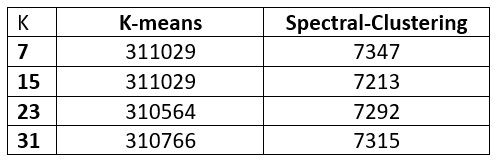

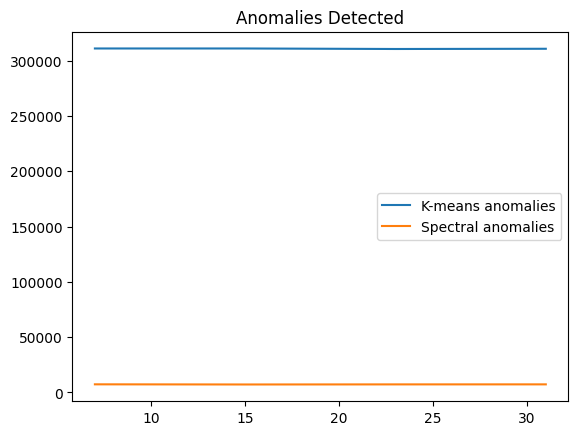

In [ ]:
fig, ax = plt.subplots()
ax.plot(Ks[:4], anomalies_kmeans, label='K-means anomalies')
ax.plot(Ks[:4], anomalies_spectral, label='Spectral anomalies')
ax.legend()
ax.set_title('Anomalies Detected')
plt.show()

#4 validation and new technique

In [ ]:
def map_predicted_labels(y_true, y_pred):
    # Compute the adjusted Rand score between the true and predicted labels
    score = adjusted_rand_score(y_true, y_pred)
    print("Adjusted Rand score:", score)

    # Create a dictionary to map predicted labels to true labels
    label_map = {}
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    for pred_label in pred_labels:
        best_match = -1
        for true_label in true_labels:
            intersect = np.intersect1d(np.where(y_pred == pred_label), np.where(y_true == true_label))
            if len(intersect) > best_match:
                label_map[pred_label] = true_label
                best_match = len(intersect)

    # Map the predicted labels to the true labels
    y_mapped = np.vectorize(label_map.get)(y_pred)

    return y_mapped

In [ ]:
import numpy as np
from sklearn.metrics.cluster import contingency_matrix

def validation(labels_true, labels_pred_):
    
    # we first map prediction labels to true labels
    labels_pred = map_predicted_labels(labels_true, labels_pred_)
    contingency = contingency_matrix(labels_true, labels_pred)
    row_sums = np.sum(contingency, axis=1)
    col_sums = np.sum(contingency, axis=0)
    total_samples = np.sum(row_sums)
    
    # Precision
    precision = np.sum(np.max(contingency, axis=0)) / total_samples
    
    # Recall
    recall = np.sum(np.max(contingency, axis=1)) / total_samples
    
    # F-score
    f_score = 2 * precision * recall / (precision + recall)
    
    # Conditional entropy
    eps = np.finfo(float).eps
    row_prob = row_sums / total_samples
    col_prob = col_sums / total_samples
    joint_prob = contingency / total_samples
    entropy_row = -np.sum(row_prob * np.log2(row_prob + eps))
    entropy_col = -np.sum(col_prob * np.log2(col_prob + eps))
    entropy_joint = -np.sum(joint_prob * np.log2(joint_prob + eps))
    conditional_entropy = entropy_joint - entropy_col
    return precision, recall, f_score, conditional_entropy


In [ ]:
print("count of each cluster in total labeled data in kddcup.data_10_percent.gz : ")
for i in range(23):
  print("cluster "+str(i)+" : "+str(np.sum((data_spectral_labels==i) == True)))

count of each cluster in total labeled data in kddcup.data_10_percent.gz : 
cluster 0 : 2203
cluster 1 : 30
cluster 2 : 8
cluster 3 : 53
cluster 4 : 12
cluster 5 : 12481
cluster 6 : 21
cluster 7 : 9
cluster 8 : 7
cluster 9 : 1072017
cluster 10 : 2316
cluster 11 : 972781
cluster 12 : 3
cluster 13 : 4
cluster 14 : 264
cluster 15 : 10413
cluster 16 : 10
cluster 17 : 15892
cluster 18 : 2807886
cluster 19 : 2
cluster 20 : 979
cluster 21 : 1020
cluster 22 : 20


In [ ]:
print("count of each cluster in sampled data : ")
for i in range(23):
  print("cluster "+str(i)+" : "+str(np.sum((my_labels==i) == True)))

count of each cluster in sampled data : 
cluster 0 : 3
cluster 1 : 0
cluster 2 : 0
cluster 3 : 0
cluster 4 : 0
cluster 5 : 19
cluster 6 : 0
cluster 7 : 0
cluster 8 : 0
cluster 9 : 1562
cluster 10 : 3
cluster 11 : 1458
cluster 12 : 0
cluster 13 : 0
cluster 14 : 0
cluster 15 : 14
cluster 16 : 0
cluster 17 : 22
cluster 18 : 4264
cluster 19 : 0
cluster 20 : 0
cluster 21 : 2
cluster 22 : 0


In [ ]:
my_data.shape

(7347, 41)

In [ ]:

def dbscan(X, eps, min_samples):
    X = StandardScaler().fit_transform(X)
    # Initialize labels as -1 (unclassified)
    labels = np.full(X.shape[0], -1)

    # Initialize the core samples set
    core_samples = set()

    # Compute pairwise distances
    D = euclidean_distances(X)

    # Find all core samples
    for i in range(X.shape[0]):
        # Find all samples within eps distance
        neighbors = np.where(D[i] <= eps)[0]

        # Check if there are enough samples to form a dense region
        if len(neighbors) >= min_samples:
            core_samples.add(i)

    # Expand clusters from core samples
    cluster_id = 0
    for i in range(X.shape[0]):
        if labels[i] == -1 and i in core_samples:
            # Start a new cluster
            cluster_id += 1
            labels[i] = cluster_id

            # Expand the cluster using depth-first search
            stack = [i]
            while stack:
                j = stack.pop()

                # Find all samples within eps distance
                neighbors = np.where(D[j] <= eps)[0]

                # Check if there are enough samples to form a dense region
                if len(neighbors) >= min_samples:
                    for k in neighbors:
                        if labels[k] == -1:
                            # Add k to the current cluster
                            labels[k] = cluster_id
                            stack.append(k)
                        elif labels[k] == 0:
                            # Add k to the current cluster and mark as border
                            labels[k] = cluster_id

    return labels


In [ ]:
# l = [1,3,5,7,10,12,15,20]
# for i in l :
#   labels = dbscan(my_data, 0.3, i)
#   p,r,f,e = validation(my_labels,labels)
#   print(p)
#   print(r)
#   print(f)
#   print(e)

In [ ]:
labels = dbscan(my_data, 0.3, 10)

**new technique validation**

In [ ]:
p,r,f,e = validation(my_labels,labels)
print("percision : ",p)
print("recall : ",r)
print("F score : ",f)
print("coditional entropy : ",e)

Adjusted Rand score: 0.9060536967540196
percision :  0.9757724241186879
recall :  0.9843473526609501
F score :  0.9800411320361573
coditional entropy :  0.16006450379662795


**spectral validation**

In [ ]:
# validate spectral prediction
p,r,f,e = validation(my_labels,spectral_labels)
print("percision : ",p)
print("recall : ",r)
print("F score : ",f)
print("coditional entropy : ",e)

Adjusted Rand score: 0.6690520335926263
percision :  0.9865251122907309
recall :  0.9908806315502926
F score :  0.9886980750931333
coditional entropy :  0.11289811916537462


**kmeans validation**

In [ ]:
print(test_kmeans_true[:50])

[16 16 16 28 28 28 16 16 28 16 28 16 16 28 16 16 16 16 28 28 16 28 16 16
 16 16 16 16 16 28 28 16 28 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 28 28]


In [ ]:
validation(test_kmeans_true, test_kmeans_clusters_k7)

Adjusted Rand score: 0.00863579884866437


(0.5359210877442296, 0.991579563320462, 0.6957881134639783, 1.987249400277048)

In [ ]:
validation(test_kmeans_true, test_kmeans_clusters_k15)

Adjusted Rand score: 0.4200811832679274


(0.7464770166125988, 0.957418761594578, 0.8388906292802026, 0.9885101646439609)

In [ ]:
validation(test_kmeans_true, test_kmeans_clusters_k23)

Adjusted Rand score: 0.4604327580608341


(0.8033302360873101,
 0.9088252220854004,
 0.8528276760559445,
 0.7958765715502201)

In [ ]:
validation(test_kmeans_true, test_kmeans_clusters_k31)

Adjusted Rand score: 0.46679483124670096


(0.8232833594295066,
 0.8835381909725459,
 0.8523472062756677,
 0.7323634400505512)

In [ ]:
validation(test_kmeans_true, test_kmeans_clusters_k45)

Adjusted Rand score: 0.38339176027161914


(0.9226760205639989, 0.981027492613229, 0.9509574749248086, 0.4667259162811004)

In [ ]:
# rand_score_kmeans = [0.00863579884866437, 0.4200811832679274, 0.4604327580608341, 0.46679483124670096, 0.38339176027161914]
precision_kmeans = [0.5359210877442296, 0.7464770166125988, 0.8033302360873101, 0.8232833594295066, 0.9226760205639989]
recall_kmeans = [0.991579563320462, 0.957418761594578, 0.9088252220854004, 0.8835381909725459, 0.981027492613229]
f1score_kmeans = [0.6957881134639783, 0.8388906292802026, 0.8528276760559445, 0.8523472062756677, 0.9509574749248086]
condEntropy_kmeans = [1.987249400277048, 0.9885101646439609, 0.7958765715502201, 0.7323634400505512, 0.4667259162811004]

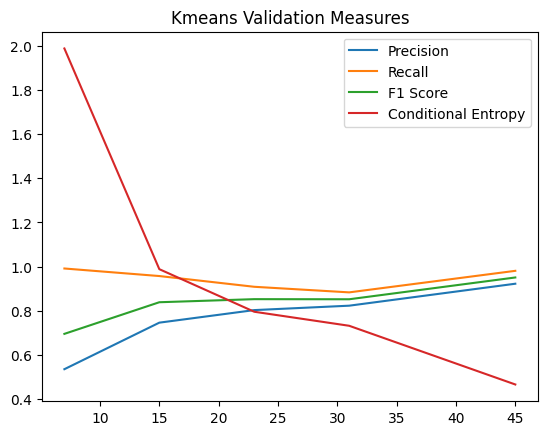

In [ ]:
# for i in range(len(Ks)):
Ks = [7, 15, 23, 31, 45]
fig, ax = plt.subplots()
# ax.plot(Ks, rand_score_kmeans, label='Rand Score')
ax.plot(Ks, precision_kmeans, label='Precision')
ax.plot(Ks, recall_kmeans, label='Recall')
ax.plot(Ks, f1score_kmeans, label='F1 Score')
ax.plot(Ks, condEntropy_kmeans, label='Conditional Entropy')
ax.legend()
ax.set_title('Kmeans Validation Measures')
plt.show()